In [2]:
import xarray as xr
import s3fs

In [3]:
fs_s3 = s3fs.S3FileSystem(anon=False)
path = 's3://gdas-data/'
flist = fs_s3.glob(path+'temp.nc')
print(flist)

['gdas-data/temp.nc']


In [4]:
s3path = 's3://'+flist[0]
remote_file_obj = fs_s3.open(s3path, mode='rb')
ds = xr.open_dataset(remote_file_obj)
print(ds)

<xarray.Dataset>
Dimensions:  (time: 5557, lat: 65, lon: 37)
Dimensions without coordinates: time, lat, lon
Data variables:
    temp     (time, lat, lon) float64 ...
    date     (time) datetime64[ns] ...


In [5]:
data = ds['temp'][-1,:,:].values

In [6]:
import pandas as pd
time = ds['date'].values
df_time = pd.DataFrame({'datetime': time})
time_str = str(df_time['datetime'].iloc[-1])

In [7]:
print(time_str)

2023-10-21 06:00:00


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator, FuncFormatter

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [9]:
from scipy.ndimage import gaussian_filter

In [10]:
sigma = 1.0  # Adjust the sigma value for the desired smoothing effect
smoothed_data = gaussian_filter(data, sigma)

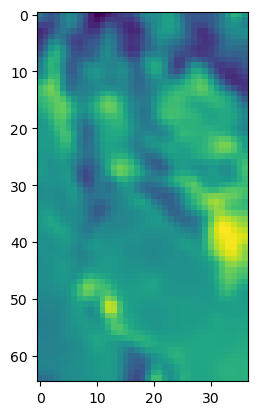

In [11]:
plt.imshow(smoothed_data)

In [12]:
pdata = smoothed_data

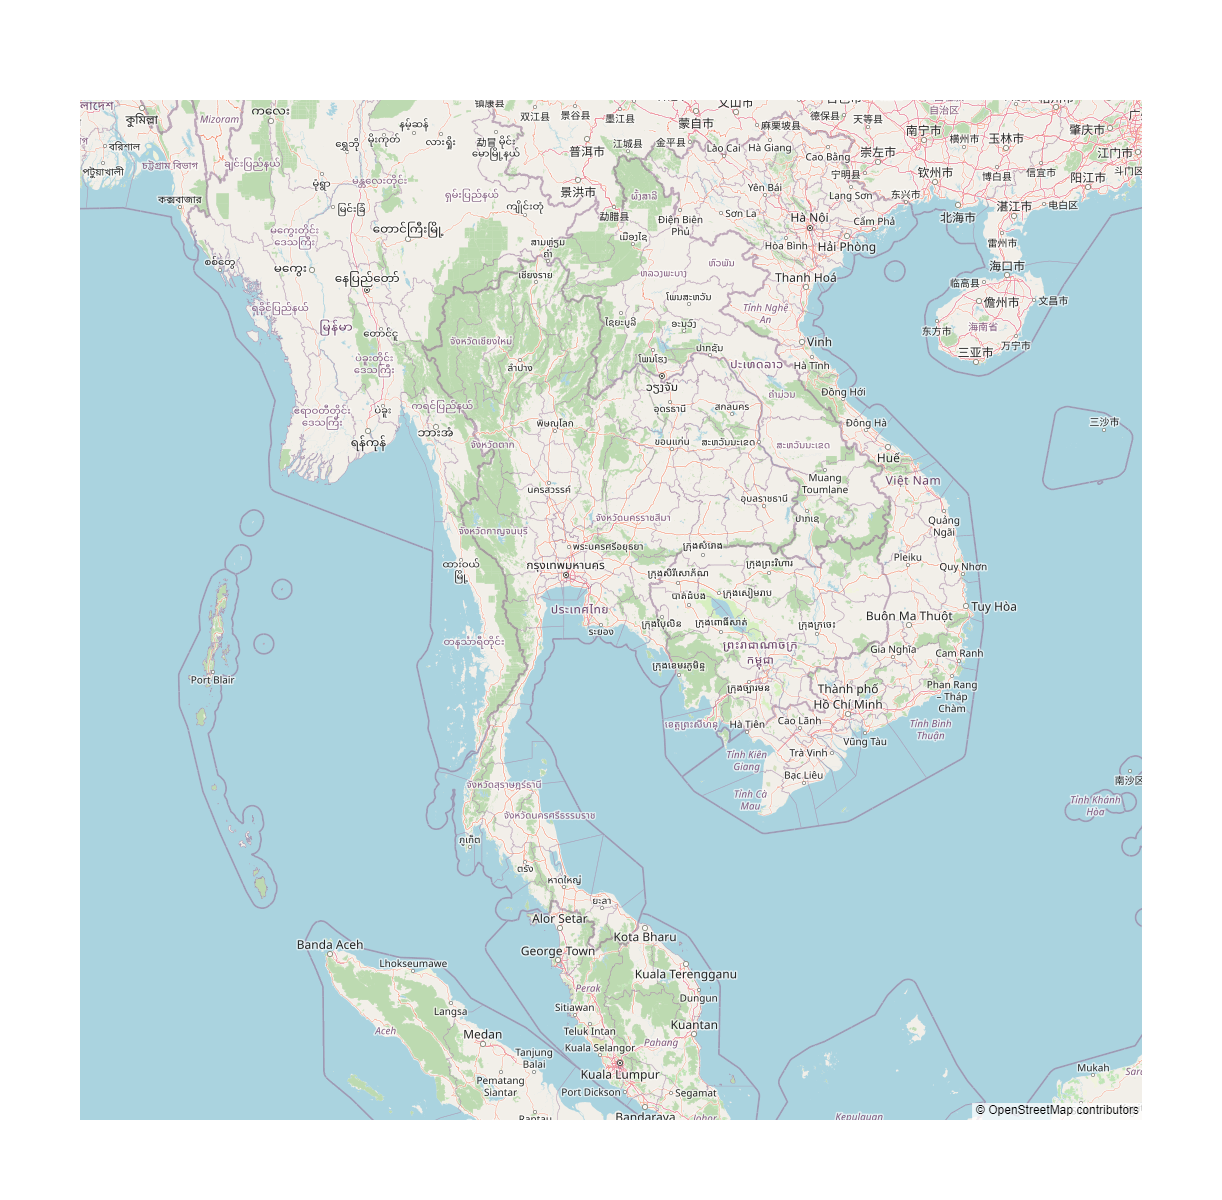

In [13]:
import plotly.graph_objects as go

# Create a scattermapbox trace with a single point at the center
trace = go.Scattermapbox(
    mode="markers",
    marker=dict(size=0),  # No visible marker
    lon=[(97 + 106) / 2],  # Center longitude
    lat=[(5 + 21) / 2],  # Center latitude
)

# Create a layout with the fixed map dimensions and specified bounds
layout = go.Layout(
    autosize=False,
    width=10*80,  # Adjust the width as needed
    height=15*80,  # Adjust the height as needed
    mapbox=dict(
        center=dict(
            lon=(97 + 106) / 2,
            lat=(5 + 21) / 2,
        ),
        zoom=5,  # Adjust the zoom level as needed
        style="open-street-map",  # Choose a map style (e.g., "basic", "stamen-terrain", "carto-positron")
    ),
    geo=dict(
        showland=True,
        landcolor="rgb(243, 243, 243)",
    ),
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Show the map
fig.show()


In [14]:
# extract (65,37) 0.25 grid lat/lon
lat_arr = np.arange(65)*0.25+5
lat_arr = np.flip(lat_arr)
lon_arr = np.arange(37)*0.25+97
lat_2d = np.broadcast_to(lat_arr[:, np.newaxis], (len(lat_arr), len(lon_arr)))
lon_2d = np.broadcast_to(lon_arr, (len(lat_arr), len(lon_arr)))

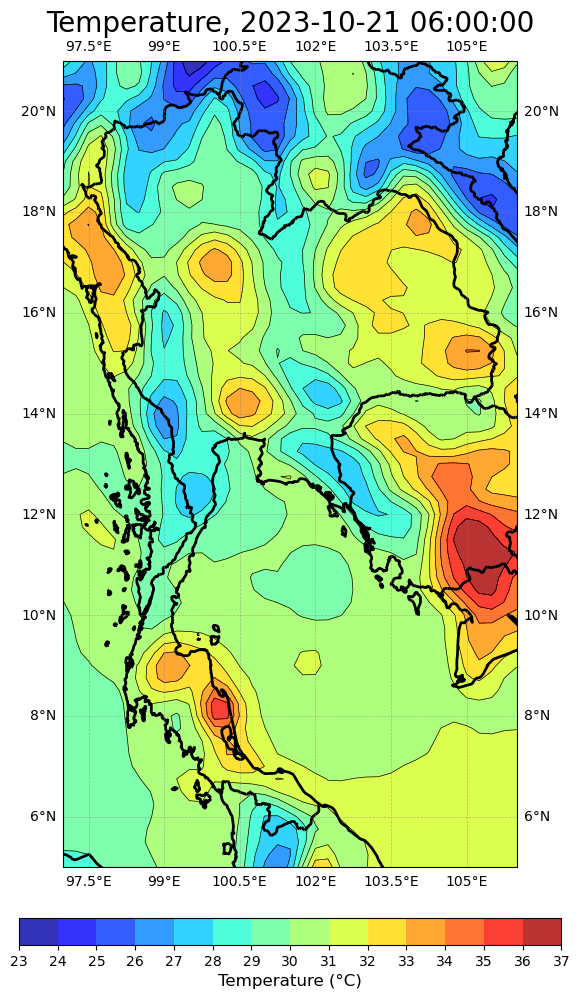

In [15]:
map_title = f'Temperature, {time_str}'

fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(2, 1, height_ratios=[12, 0.5])  # Reduced the height ratio of the color bar
ax = plt.subplot(gs[0], projection=ccrs.PlateCarree())
ax.set_extent([97, 106, 5, 21], crs=ccrs.PlateCarree())  # [lon0, lon1, lat0, lat1]

# Create contour plot with color
cmap_r = plt.get_cmap('jet')
vmin = np.floor(np.min(pdata))
vmax = np.ceil(np.max(pdata))

contour_levels = np.arange(vmin, vmax+1, 1)  # Contour levels from 0 to 60 with a step of 5
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
contourf = ax.contourf(lon_2d, lat_2d, pdata, cmap=cmap_r, levels=contour_levels, norm=norm, transform=ccrs.PlateCarree(), alpha=0.8)
contour = ax.contour(lon_2d, lat_2d, pdata, levels=contour_levels, colors='k', linewidths=0.5, transform=ccrs.PlateCarree())

# Add a color bar
cbar = plt.colorbar(contourf, ax=ax, orientation='horizontal', pad=0.05, shrink=0.7, ticks=np.arange(vmin, vmax + 1, 1))
def format_ticks(value, _):
    return f'{int(value)}'

cbar.ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
cbar.set_label('Temperature (°C)', fontsize=12)  # Add your title here and adjust the fontsize as needed

ax.set_title(map_title, fontsize=20)
ax.add_feature(cfeature.COASTLINE, linewidth=2)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black', linewidth=2)

ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')


plt.show()

In [16]:
# input location coordinates here
lat = 15.7241
lon = 100.3972
lat_str = str(round(lat,3))
lon_str = str(round(lon,3))

In [17]:
import numpy as np
from potomac_lib.cal import bilinear_interpolation

In [18]:
all_data = ds['temp'].squeeze()
num_samples = all_data.shape[0]
num_samples

5557

In [19]:
loc_values = np.empty(num_samples)

for i in range(num_samples):
    fdata = all_data[i, :, :].squeeze()
    fdata_loc = bilinear_interpolation(lat, lon, fdata)

    loc_values[i] = round(fdata_loc, 2)

In [20]:
# extract value after assign coordinate and bilinear interpolation 
datetime_values = ds['date'].values
temp_values = loc_values

In [21]:
import pandas as pd

In [22]:
# datetime is still in UTC
df = pd.DataFrame({'datetime': datetime_values, 'temp': temp_values})

In [23]:
# Extract year, month, day, and hour columns
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

In [24]:
pivot_df = df.pivot_table(index=['year', 'month', 'day'], columns='hour', values='temp', aggfunc='first')

In [25]:
pivot_df.columns = ['T00', 'T06', 'T12', 'T18']
pivot_df.reset_index(inplace=True)

In [26]:
pivot_df['date'] = pivot_df['year'].astype(str) + '-' + pivot_df['month'].astype(str).str.zfill(2) + '-' + pivot_df['day'].astype(str).str.zfill(2)
pivot_df.drop(['year', 'month', 'day'], axis=1, inplace=True)
pivot_df = pivot_df[['date', 'T00', 'T06', 'T12', 'T18']]

In [27]:
pivot_df = pivot_df.copy()
pivot_df['min'] = pivot_df[['T00', 'T06', 'T12', 'T18']].min(axis=1)
pivot_df['max'] = pivot_df[['T00', 'T06', 'T12', 'T18']].max(axis=1)


In [28]:
# copy data fram to be plotted
df2 = pivot_df

In [29]:
df2.tail()

date    T00    T06    T12    T18    min    max
1385  2023-10-17  24.39  34.05  25.35  23.28  23.28  34.05
1386  2023-10-18  24.85  34.45  25.46  23.86  23.86  34.45
1387  2023-10-19  25.40  35.13  26.32  23.30  23.30  35.13
1388  2023-10-20  25.15  35.44  25.06  25.08  25.06  35.44
1389  2023-10-21  24.34  31.81    NaN    NaN  24.34  31.81

In [30]:
import plotly.graph_objects as go

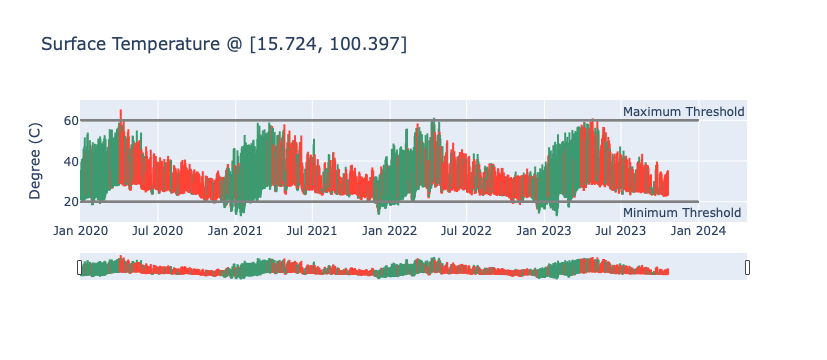

In [31]:
fig = go.Figure(data=[go.Candlestick(x=df2['date'],
                open=df2['T00'],
                high=df2['max'],
                low=df2['min'],
                close=df2['T18'])])


fig.update_layout(
    title=f'Surface Temperature @ [{lat_str}, {lon_str}]',
    yaxis_title=f'Degree (C)',
    shapes=[
        dict(
            x0='2020-01-01',
            x1='2023-12-31',  # Adjust the end date as needed
            y0=60,  # You can set the y-value to your desired level
            y1=60,
            xref='x',
            yref='y',
            line=dict(color='gray', width=2)
        ),
        dict(  # Add a comma here
            x0='2020-01-01',
            x1='2023-12-31',  # Adjust the end date as needed
            y0=20,  # You can set the y-value to your desired level
            y1=20,
            xref='x',
            yref='y',
            line=dict(color='gray', width=2)
        )
    ],
    annotations=[
        dict(
            x='2023-7-1',
            y=60 + 5,  # You can adjust the y-position as needed
            xref='x',
            yref='y',
            showarrow=False,
            xanchor='left',
            text='Maximum Threshold'
        ),
        dict(
            x='2023-7-1',
            y=10 + 5,  # You can adjust the y-position as needed
            xref='x',
            yref='y',
            showarrow=False,
            xanchor='left',
            text='Minimum Threshold'
        ),
    ]
)

# Set the y-axis range to start from 0
fig.update_yaxes(range=[10, 70])

fig.show()

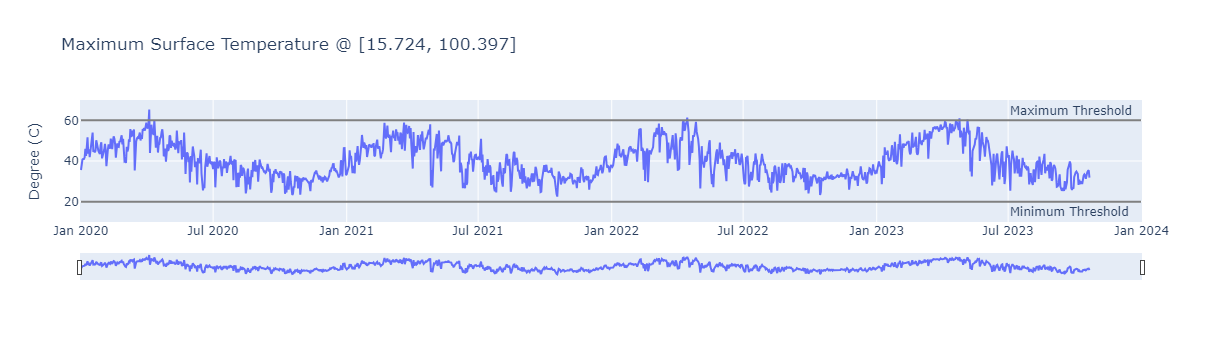

In [32]:
fig = go.Figure([go.Scatter(x=df2['date'], y=df2['max'])])

fig.update_layout(xaxis_rangeslider_visible=True)

fig.update_layout(
    title=f'Maximum Surface Temperature @ [{lat_str}, {lon_str}]',
    yaxis_title=f'Degree (C)',
    shapes=[
        dict(
            x0='2020-01-01',
            x1='2023-12-31',  # Adjust the end date as needed
            y0=60,  # You can set the y-value to your desired level
            y1=60,
            xref='x',
            yref='y',
            line=dict(color='gray', width=2)
        ),
        dict(  # Add a comma here
            x0='2020-01-01',
            x1='2023-12-31',  # Adjust the end date as needed
            y0=20,  # You can set the y-value to your desired level
            y1=20,
            xref='x',
            yref='y',
            line=dict(color='gray', width=2)
        )
    ],
    annotations=[
        dict(
            x='2023-7-1',
            y=60 + 5,  # You can adjust the y-position as needed
            xref='x',
            yref='y',
            showarrow=False,
            xanchor='left',
            text='Maximum Threshold'
        ),
        dict(
            x='2023-7-1',
            y=10 + 5,  # You can adjust the y-position as needed
            xref='x',
            yref='y',
            showarrow=False,
            xanchor='left',
            text='Minimum Threshold'
        ),
    ]
)

# Set the y-axis range to start from 0
fig.update_yaxes(range=[10, 70])

fig.show()